# Preparations

<b>Load Libraries</b>

In [1]:
# udf 
import os, sys
cwd = os.getcwd()
os.chdir('../')
path_to_src = os.getcwd()
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
os.chdir(cwd)
##
from src.notebook.support import *
from src.mlflow.support import *

# others 
from warnings import simplefilter

<b>Load Dataset</b>

In [2]:
# materials
materials = prepare_data_to_train(path='../cache/data/cleaned.csv')

<b>MLflow</b>

In [3]:
# local server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
experiment_name = 'Feature engineering'
try:
    mlflow.create_experiment(name=experiment_name, artifact_location='cache/mlflow/runs/')
except:
    mlflow.set_experiment(experiment_name=experiment_name)

In [4]:
# tags
tags = {'pre_pro': None, 'base_model': None, 
        'feature_selection': 'false', 'beta_f': 2}

# metrics
metrics = {'avg_fbeta': None, 'val_fbeta': None}

# 1. Baseline Evaluation

In [5]:
# dtype's indexs separation
num_iters = materials['X_train'].shape[1]
num_idxes, cat_idxes = [], []
for i in range(num_iters):
    try:
        float(materials['X_train'][0, i])
        num_idxes.append(i)
    except:
        cat_idxes.append(i)

In [11]:
# warnings
simplefilter(action='ignore')

# base models
base_models = load_base_models()

# trasnformers
ct = ColumnTransformer([('num', SimpleImputer(strategy='mean'), num_idxes), 
                        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)])

# pipeline
pipelines = []
for name, model in base_models:
    pipeline = Pipeline([('trans', ct), 
                         (name, model)])
    pipelines.append((name, pipeline))

kfold_results = get_kfold_results(pipelines, materials['X_train'], materials['y_train'])

LR: 0.5520175761327805 (0.030887628184530093)
KNN: 0.45807864096365475 (0.04355683627620326)
SVM: 0.0 (0.0)
CART: 0.4981312033510239 (0.033849637678206215)
ET: 0.47802201863592086 (0.040517659704176)
RF: 0.5000427656656062 (0.044936523146706125)
GB: 0.5258548548429957 (0.04106858667872607)
LGBM: 0.5304747147473603 (0.047610958849305926)
XGB: 0.5259580611451045 (0.04950461047986286)


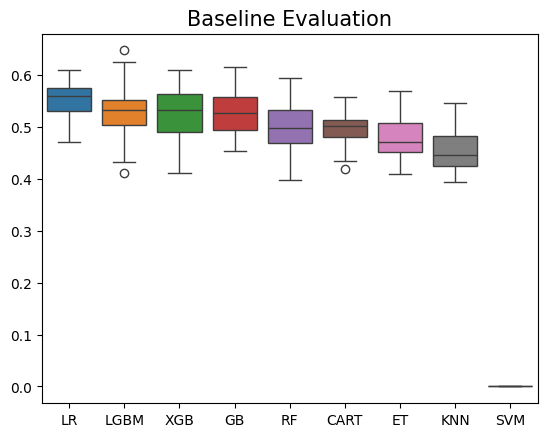

In [12]:
# plot kfold results
plot_kfold_results(kfold_results, 'Baseline Evaluation')

In [13]:
# mlflow
for name, pipeline in pipelines:
    ##
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(y_true=materials['y_test'], y_pred=val_predictions, 
                            beta=2)
    ##
    with mlflow.start_run():
        ### tags
        tags['pre_pro'] = 'si(mean)_ohe'
        tags['base_model'] = name
        mlflow.set_tags(tags)
        ###
        metrics['avg_fbeta'] = kfold_results[name].mean()
        metrics['val_fbeta'] = val_fbeta
        mlflow.log_metrics(metrics)
        ###
        mlflow.sklearn.log_model(artifact_path='model', 
                                 sk_model=pipeline)

In [14]:
# infer pip requirements
runs_id = mlflow.search_runs(
    filter_string="tags.base_model = 'LR' and tags.pre_pro = 'si(mean)_ohe'"
)['run_id'].values[0]
pip_requirements = infer_pip_requirements(
    model_uri=f'runs:/{runs_id}/model', 
    flavor='sklearn'
)
pip_requirements.extend(['mlxtend==0.23.1'])
pip_requirements

['cloudpickle==3.0.0',
 'imbalanced-learn==0.12.3',
 'numpy==1.26.4',
 'psutil==6.0.0',
 'scikit-learn==1.5.1',
 'scipy==1.14.0',
 'mlxtend==0.23.1']

# 2. Scaling

<b>Standardization</b>

In [15]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask].tolist(), idxes[~mask].tolist()

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

std = Node('std', StandardScaler())
std.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), StandardScaler()))
impute.test = impute_test
std.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

left = [std, impute]
right = [ohe]

tree = InitBinaryTree(left, right)

In [16]:
# warnings
simplefilter(action='ignore')

# artifacts path
artifacts_path = {'feature_selector': '../cache/temp/feature_selector.pkl', 
                  'model': '../cache/temp/model.pkl'}

# base model CHANGE HERE
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFSTransformer(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2),
    verbose=2
)
sfs.fit(materials['X_train'], materials['y_train'])
## dump sfs
dump_model(sfs, artifacts_path['feature_selector'])
## dump pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-16 13:05:03] Features: 1/19 -- score: 0.0
[2024-08-16 13:05:12] Features: 2/19 -- score: 0.0040347610180012415
[2024-08-16 13:05:41] Features: 3/19 -- score: 0.49741269079058165
[2024-08-16 13:05:51] Features: 4/19 -- score: 0.5254153342033828
[2024-08-16 13:05:42] Features: 5/19 -- score: 0.5425991013647582
[2024-08-16 13:05:52] Features: 6/19 -- score: 0.5505785077858477
[2024-08-16 13:06:02] Features: 7/19 -- score: 0.5612207838863971
[2024-08-16 13:06:30] Features: 8/19 -- score: 0.5620238151449702
[2024-08-16 13:06:20] Features: 9/19 -- score: 0.5618624342920723
[2024-08-16 13:06:29] Features: 10/19 -- score: 0.563125579114382
[2024-08-16 13:06:39] Features: 11/19 -- score: 0.5601032948132362
[2024-08-16 13:06:49] Features: 12/19 -- score: 0.5593827611240959
[2024-08-16 13:06:58] Features: 13/19 -- score: 0.5559667735770113
[2024-08-16 13:07:25] Features: 14/19 -- score: 0.5525668524005467
[2024-08-16 13:07:13] Features: 15/19 -- score: 0.5533497249031317
[2024-08-16 13:

In [17]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(y_true=materials['y_test'], y_pred=val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    tags['pre_pro'] = 'si(mean)_std_ohe'
    tags['base_model'] = 'LR' # CHANGE HERE
    tags['feature_selection'] = 'true'
    mlflow.set_tags(tags)
    ### metrics
    metrics['avg_fbeta'] = sfs.k_score_
    metrics['val_fbeta'] = val_fbeta
    mlflow.log_metrics(metrics)
    ### pipeline
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(), 
                            artifacts=artifacts_path,
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

<b>Power Transformation</b>

In [18]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask], idxes[~mask]

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('pwt', PowerTransformer(method='yeo-johnson'))
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), PowerTransformer(method='yeo-johnson')))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [19]:
# warnings
simplefilter(action='ignore')

# artifacts path
artifacts_path = {'feature_selector': '../cache/temp/feature_selector.pkl', 
                  'model': f'../cache/temp/model.pkl'}

# base model CHANGE HERE
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFSTransformer(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(materials['X_train'], materials['y_train'])
## dump 
dump_model(sfs, artifacts_path['feature_selector'])
## pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-16 13:08:45] Features: 1/19 -- score: 0.3367014094643303
[2024-08-16 13:09:15] Features: 2/19 -- score: 0.46211287021653413
[2024-08-16 13:09:08] Features: 3/19 -- score: 0.4888495874775545
[2024-08-16 13:09:19] Features: 4/19 -- score: 0.5141071788662007
[2024-08-16 13:09:32] Features: 5/19 -- score: 0.5345083941939138
[2024-08-16 13:09:45] Features: 6/19 -- score: 0.5362574421975129
[2024-08-16 13:10:16] Features: 7/19 -- score: 0.5411422405538644
[2024-08-16 13:10:09] Features: 8/19 -- score: 0.5426828177281955
[2024-08-16 13:10:20] Features: 9/19 -- score: 0.5470241786308967
[2024-08-16 13:10:31] Features: 10/19 -- score: 0.5483868941250314
[2024-08-16 13:10:41] Features: 11/19 -- score: 0.5496071808896537
[2024-08-16 13:10:52] Features: 12/19 -- score: 0.5470044265236076
[2024-08-16 13:11:02] Features: 13/19 -- score: 0.5468527227695874
[2024-08-16 13:11:11] Features: 14/19 -- score: 0.5452672639235593
[2024-08-16 13:11:19] Features: 15/19 -- score: 0.536243888799834
[20

In [20]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    tags['pre_pro'] = 'si(mean)_pwt_ohe'
    tags['base_model'] = 'LR' # CHANGE HERE
    tags['feature_selection'] = 'true'
    mlflow.set_tags(tags)
    ### metrics
    metrics['avg_fbeta'] = sfs.k_score_
    metrics['val_fbeta'] = val_fbeta
    mlflow.log_metrics(metrics)
    ### log
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(),
                            artifacts=artifacts_path, 
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

<b>Quantile Transformation</b>

In [21]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask], idxes[~mask]

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('qtt', QuantileTransformer(output_distribution='normal'))
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), QuantileTransformer(output_distribution='normal')))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [22]:
# warnings
simplefilter(action='ignore')

# artifacts_path
artifacts_path = {'feature_selector': '../cache/temp/feature_selector.pkl', 
                  'model': f'../cache/temp/model.pkl'}

# base model 
base_model = get_seleted_models(['LR']) # CHANGE HERE

# transformers
transformers = SFSTransformer(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2

)
sfs.fit(materials['X_train'], materials['y_train'])
## dump
dump_model(sfs, artifacts_path['feature_selector'])
## pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-16 13:11:48] Features: 1/19 -- score: 0.23108849329963782
[2024-08-16 13:11:59] Features: 2/19 -- score: 0.46188856730999023
[2024-08-16 13:12:10] Features: 3/19 -- score: 0.4924854072177371
[2024-08-16 13:12:22] Features: 4/19 -- score: 0.5105268930117834
[2024-08-16 13:12:33] Features: 5/19 -- score: 0.5316081070338607
[2024-08-16 13:12:44] Features: 6/19 -- score: 0.5473301054174278
[2024-08-16 13:12:55] Features: 7/19 -- score: 0.5457275745895974
[2024-08-16 13:13:05] Features: 8/19 -- score: 0.5470891602293279
[2024-08-16 13:13:16] Features: 9/19 -- score: 0.5442946780891177
[2024-08-16 13:13:26] Features: 10/19 -- score: 0.544926914797244
[2024-08-16 13:13:35] Features: 11/19 -- score: 0.5448442596255467
[2024-08-16 13:13:46] Features: 12/19 -- score: 0.5442618064851227
[2024-08-16 13:13:55] Features: 13/19 -- score: 0.5491271927819026
[2024-08-16 13:14:04] Features: 14/19 -- score: 0.5507532890996242
[2024-08-16 13:14:31] Features: 15/19 -- score: 0.5526826666275856
[2

In [24]:
# mflow
## 
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    tags['pre_pro'] = 'si(mean)_qtt_ohe'
    tags['base_model'] = 'LR' # CHANGE HERE
    tags['feature_selection'] = 'true'
    mlflow.set_tags(tags)
    ### metrics
    metrics['avg_fbeta'] = sfs.k_score_
    metrics['val_fbeta'] = val_fbeta
    mlflow.log_metrics(metrics)
    ###
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(), 
                            artifacts=artifacts_path, 
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

# 3. Factor Analysis

# 4. Resampling

In [30]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask].tolist(), idxes[~mask].tolist()

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('std', StandardScaler())
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), StandardScaler()))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [31]:
# data
run_id = mlflow.search_runs(
    filter_string="tags.base_model = 'LR' and tags.pre_pro = 'si(mean)_qtt_ohe'", # CHANGE HERE
    order_by=["metrics.avg_fbeta DESC"]
)['run_id'].values[0]
path = mlflow.artifacts.download_artifacts(f"runs:/{run_id}/model/artifacts/feature_selector.pkl")
with open(path, 'rb') as f:
    sfs = cloudpickle.load(f)
    selected_X_train = sfs.transform(materials['X_train'])
##
artifacts_path = {'feature_selector': path}

In [32]:
# warnings
simplefilter(action='ignore')

# resamplers
resamplers = load_resammplers()

# base model
base_model = get_seleted_models(['LR']) # CHANGE HERE

# transformers
transformers = SFSTransformer(tree)

# evaluation 
kfold_results = dict()
for name, resampler in resamplers:
    ##
    pipeline = [(name, Pipeline([('trans', transformers), (name, resampler)] + base_model))]
    cv_results = get_kfold_results(pipeline, selected_X_train, materials['y_train'])
    kfold_results.update(cv_results)
    ##
    _, pipeline = pipeline[0]
    pipeline.fit(selected_X_train, materials['y_train'])
    artifacts_path['model'] = f'../cache/temp/model.pkl'
    dump_model(pipeline, artifacts_path['model'])
    ## mlflow
    val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
    val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                            beta=2)
    with mlflow.start_run():
        ### tags
        tags['base_model'] = 'LR' # CHANGE HERE
        tags['pre_pro'] = f'si(mean)_qtt_ohe_{name.lower()}' # CHANGE HERE
        tags['feature_selection'] = 'true'
        mlflow.set_tags(tags)
        ### metrics
        metrics['avg_fbeta'] = cv_results[name].mean()
        metrics['val_fbeta'] = val_fbeta
        mlflow.log_metrics(metrics)
        ### model
        mlflow.pyfunc.log_model(artifact_path='model', 
                                python_model=MLflowModel(), 
                                artifacts=artifacts_path, # the bug is here, assign the 'feature_selector' path too
                                signature=infer_signature(materials['X_train']),
                                pip_requirements=pip_requirements)

ROS: 0.7078405692971782 (0.03227917450125751)


SMOTE: 0.7046974059003313 (0.026899236987206348)


SMOTEENN: 0.7423793328077977 (0.01795220115283445)


SMOTETomek: 0.7115604979623584 (0.023933440738389947)


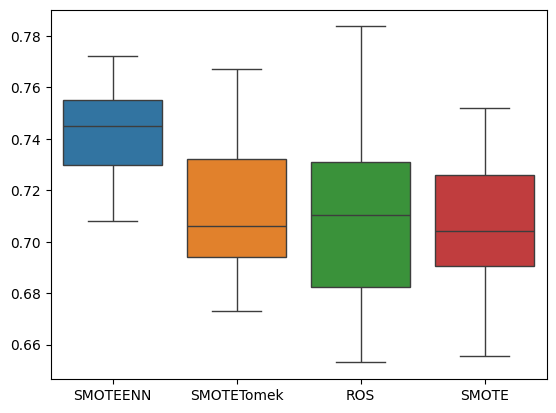

In [33]:
# plot
plot_kfold_results(kfold_results)

# 5. Finalize Model

In [36]:
# search runs
## notes: if using nodes, the function for the node should be present in memory 
run_id = mlflow.search_runs(
    filter_string="tag.pre_pro = 'si(mean)_qtt_ohe_smoteenn' and tags.base_model = 'LR'" # CHANGE HERE: be careful of the bug, which is due to wrong logging order
)['run_id'].values[0]
model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

FBeta score: 0.7509477981918927 
Classification report: 
              precision    recall  f1-score   support

           0       0.95      0.57      0.71      1552
           1       0.43      0.92      0.59       561

    accuracy                           0.66      2113
   macro avg       0.69      0.74      0.65      2113
weighted avg       0.81      0.66      0.68      2113



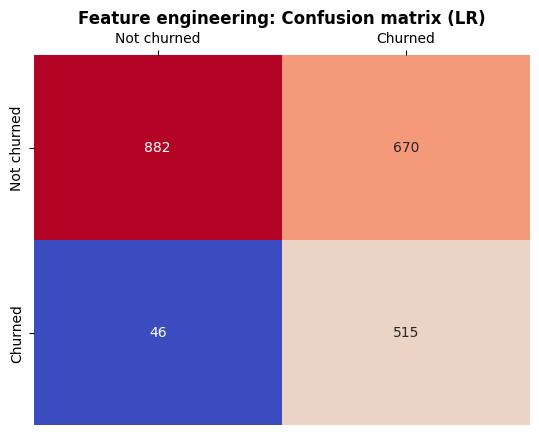

In [38]:
# make predictions 
## fbeta & classification report
val_predictions = model.predict(materials['X_test'])
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
print(f"FBeta score: {val_fbeta} \nClassification report: \n{classification_report(materials['y_test'], val_predictions)}")

## confusion matrix
data = confusion_matrix(materials['y_test'], val_predictions)
g = sns.heatmap(data, 
            annot=True, fmt='.0f', 
            cmap='coolwarm', cbar=False)
g.xaxis.tick_top()
g.set_xticklabels(['Not churned', 'Churned'])
g.set_yticklabels(['Not churned', 'Churned'])
g.set_title(label='Feature engineering: Confusion matrix (LR)', # CHANGE HERE
            fontdict=dict(weight='bold'))
g.get_figure().savefig('../cache/graphs/fe_conf_matrix_xgb_qtt.png')

plt.show()